

---

# **Imports**

In [172]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from keras.preprocessing.image import ImageDataGenerator
from prettytable import PrettyTable

In [173]:
import tensorflow as tf
import tensorflow_hub as hub

In [174]:
print("TF version:", tf.__version__)

TF version: 2.12.0


In [175]:
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Conv2D, ReLU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import ResNet50,MobileNet

In [176]:
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

No GPU, using /device:CPU:0.


In [177]:
!git clone https://github.com/umbertogriffo/focal-loss-keras.git

Cloning into 'focal-loss-keras'...
remote: Enumerating objects: 108, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 108 (delta 35), reused 44 (delta 13), pack-reused 31
Receiving objects: 100% (108/108), 91.05 KiB | 2.46 MiB/s, done.
Resolving deltas: 100% (44/44), done.


In [178]:
%cd focal-loss-keras

/content/focal-loss-keras/focal-loss-keras


In [179]:
!cp -r src/loss_function /content/

In [180]:
!pip install dill

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/




---
# **Data**


In [181]:
main_split_dir ='/content/drive/MyDrive/Image Data Split/'
print(os.listdir(main_split_dir))
train_dir ='/content/drive/MyDrive/Image Data Split/Train/'
print(os.listdir(train_dir))
test_intra_dir ='/content/drive/MyDrive/Image Data Split/Test intra/'
print(os.listdir(test_intra_dir))
test_inter_dir ='/content/drive/MyDrive/Image Data Split/Test inter/'
print(os.listdir(test_inter_dir))

['Train', 'Test intra', 'Test inter']
['Anomaly', 'Normal', 'Poor Quality']
['Normal', 'Anomaly', 'Poor Quality']
['Normal', 'Anomaly', 'Poor Quality']


In [182]:
#train
num_train_normal= len(os.listdir(train_dir+'Normal/'))
num_train_anomaly = len(os.listdir(train_dir+'Anomaly/'))
num_train_poor = len(os.listdir(train_dir+'Poor Quality/'))
Tot_train =  num_train_poor + num_train_anomaly + num_train_normal             

#test intra
num_test_intra_normal = len(os.listdir(test_intra_dir+'Normal/'))
num_test_intra_anomaly = len(os.listdir(test_intra_dir+'Anomaly/'))
num_test_intra_poor = len(os.listdir(test_intra_dir+'Poor Quality/'))
Tot_test_intra =  num_test_intra_normal + num_test_intra_anomaly + num_test_intra_poor

#test inter
num_test_inter_normal = len(os.listdir(test_inter_dir+'Normal/'))
num_test_inter_anomaly = len(os.listdir(test_inter_dir+'Anomaly/'))
num_test_inter_poor = len(os.listdir(test_inter_dir+'Poor Quality/'))
Tot_test_inter =  num_test_inter_normal + num_test_inter_anomaly + num_test_inter_poor

#table stat general
t = PrettyTable(['Class','Train','Test intra','Test inter'])
t.add_row(['Normal',num_train_normal,num_test_intra_normal,num_test_inter_normal])
t.add_row(['Anomaly',num_train_anomaly,num_test_intra_anomaly,num_test_inter_anomaly])
t.add_row(['Poor Quality',num_train_poor,num_test_intra_poor,num_test_inter_poor])
t.add_row(['Total',Tot_train,Tot_test_intra,Tot_test_inter])
print(t)

+--------------+-------+------------+------------+
|    Class     | Train | Test intra | Test inter |
+--------------+-------+------------+------------+
|    Normal    |  1303 |    241     |    241     |
|   Anomaly    |  469  |    136     |    106     |
| Poor Quality |  177  |     2      |     8      |
|    Total     |  1949 |    379     |    355     |
+--------------+-------+------------+------------+


In [183]:
import pandas as pd
def create_df(directory):
    file_paths = []
    labels = []
    for class_folder in os.listdir(directory):
        class_path = os.path.join(directory, class_folder)
        if os.path.isdir(class_path):
            for file_name in os.listdir(class_path):
                if file_name.endswith('.png'): # or any other image format
                    file_path = os.path.join(class_path, file_name)
                    file_paths.append(file_path)
                    labels.append(class_folder)
    df = pd.DataFrame({'file_path': file_paths, 'label': labels})
    return df

# Create DataFrames for train, validation, and test sets
train_df = create_df(train_dir)
test_intra_df = create_df(test_intra_dir)
test_inter_df = create_df(test_inter_dir)

# Print the number of images and classes in each set
print('Train set:', len(train_df), train_df['label'].nunique())
print('Test intra set:', len(test_intra_df), test_intra_df['label'].nunique())
print('Test inter set:', len(test_inter_df), test_inter_df['label'].nunique())

Train set: 1949 3
Test intra set: 379 3
Test inter set: 355 3


In [184]:
all_df = [train_df , test_intra_df , test_inter_df]
all_df = pd.concat(all_df)

In [185]:
print('all set:', len(all_df), all_df['label'].nunique())

all set: 2683 3


In [186]:
all_df = all_df[all_df.label != 'Poor Quality']

In [187]:
print('all set:', len(all_df), all_df['label'].nunique())

all set: 2496 2


In [188]:
from sklearn.model_selection import train_test_split
# Split the DataFrame into training and testing sets
train_df, test_df = train_test_split(all_df, test_size=0.2, random_state=42, shuffle=True)

# Print the shape of the training and testing sets
print("Shape of training set:", train_df.shape)
print("Shape of testing set:", test_df.shape)

Shape of training set: (1996, 2)
Shape of testing set: (500, 2)


In [189]:
anom_nbr = len(train_df[train_df.label == 'Anomaly'])

In [190]:
Norm_nbr = len(train_df[train_df.label == 'Normal'])



---

# **Datagens and smote**

In [191]:
from imblearn.over_sampling import SMOTE
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import to_categorical

In [192]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen  = ImageDataGenerator(rescale = 1./255)

In [193]:
with tf.device(device_name):
  # Load the pre-trained MobileNet model without the top layer
  base_model = MobileNet(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

In [194]:
with tf.device(device_name):
  number_of_layers = len(base_model.layers)

In [195]:
# Freeze the % layers in the base model
percent = 0.5
number_of_layers_to_freeze =  int(number_of_layers * percent)
with tf.device(device_name):
  # Freeze some layers
  for layer in base_model.layers[:number_of_layers_to_freeze]:
      layer.trainable = False

In [196]:
# description of the model
with tf.device(device_name):
  model = Sequential()
  model.add(base_model)
  model.add(GlobalAveragePooling2D())
  model.add(BatchNormalization())
  model.add(Dropout(0.4))
  model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.005)))
  model.add(BatchNormalization())
  model.add(Dropout(0.4))
  model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.005)))
  model.add(BatchNormalization())
  model.add(Dropout(0.4))
  model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.005)))
  model.add(BatchNormalization())
  model.add(Dropout(0.4))
  model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.005)))
  model.add(Dense(2, activation='softmax'))

In [197]:
from sklearn.utils.class_weight import compute_class_weight

# Assuming your DataFrame is called df and the target column is called 'class'
class_labels = train_df['label'].unique()
class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=train_df['label'])

print("Class labels:", class_labels)
print("Class weights:", class_weights)

Class labels: ['Anomaly' 'Normal']
Class weights: [1.70307167 0.70780142]


In [198]:
class_weights_dict = dict(zip([0,1], class_weights))
print("Class weights dictionary:", class_weights_dict)

Class weights dictionary: {0: 1.7030716723549488, 1: 0.7078014184397163}


In [199]:
from loss_function.losses import binary_focal_loss
with tf.device(device_name):
  model.compile(
    optimizer="adamax",
    loss=[binary_focal_loss(alpha=0.7, gamma=2)],
    metrics=['acc'])

In [200]:
# callbacks
from tensorflow.keras import callbacks
with tf.device(device_name):
  early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=1e-7,
    restore_best_weights=True,
)

  plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.2,                                     
    patience = 2,                                   
    min_delt = 1e-7,                                
    cooldown = 0,                               
    verbose = 1
) 

  checkpoint = callbacks.ModelCheckpoint(
    '/content/drive/MyDrive/models (3 calsses)/MobileNet 5th (2c) try(conf in)/best_model.h5', 
    monitor='val_loss', 
    save_best_only=True, 
    mode='min', verbose=1
)

In [201]:
# Define the number of folds for cross-validation
num_folds = 5
# Define the cross-validation method
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

In [202]:
# Initialize lists to store the training and validation metrics for each fold
train_losses, train_accs, val_losses, val_accs = [], [], [], []

In [ ]:
# Loop over the folds
for fold, (train_idx, val_idx) in enumerate(kfold.split(train_df)):
    # Print the fold number
    print('Fold', fold+1)
    
    training_set = train_datagen.flow_from_dataframe(
            train_df.iloc[train_idx],
            x_col='file_path',
            y_col='label',
            target_size = (224, 224),
            batch_size = 64,
            class_mode = 'categorical')
    
    validation_set = val_datagen.flow_from_dataframe(
            train_df.iloc[val_idx],
            x_col='file_path',
            y_col='label',
            target_size = (224, 224),
            batch_size = 64,
            class_mode = 'categorical')

    # Train the model on the training data for this fold
    history = model.fit(training_set, epochs=10, batch_size = 64,
                        steps_per_epoch=len(training_set),
                        validation_data=validation_set, 
                        validation_steps=len(validation_set), 
                        callbacks=[early_stopping, plateau,checkpoint])
    
    # Get the training and validation metrics for this fold from the history object
    train_loss = history.history['loss'][-1]
    train_acc = history.history['acc'][-1]
    val_loss = history.history['val_loss'][-1]
    val_acc = history.history['val_acc'][-1]
    
    # Append the training and validation metrics to the respective lists
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # Print the training and validation metrics for this fold
    print(f"Training Loss: {train_loss:.4f} - Training Accuracy: {train_acc:.4f}")
    print(f"Validation Loss: {val_loss:.4f} - Validation Accuracy: {val_acc:.4f}")
   

Fold 1
Found 1596 validated image filenames belonging to 2 classes.
Found 400 validated image filenames belonging to 2 classes.
Epoch 1/10
25/25 [==============================] - ETA: 0s - loss: 11.1659 - acc: 0.6147
Epoch 1: val_loss improved from inf to 10.66404, saving model to /content/drive/MyDrive/models (3 calsses)/MobileNet 5th (2c) try(conf in)/best_model.h5
25/25 [==============================] - 167s 6s/step - loss: 11.1659 - acc: 0.6147 - val_loss: 10.6640 - val_acc: 0.6875 - lr: 0.0010


In [158]:
# Compute the mean training and validation metrics across all folds
mean_train_loss = np.mean(train_losses)
mean_train_acc = np.mean(train_accs)
mean_val_loss = np.mean(val_losses)
mean_val_acc = np.mean(val_accs)

# Print the mean training and validation metrics
print("Mean Training Loss:", mean_train_loss)
print("Mean Training Accuracy:", mean_train_acc)
print("Mean Validation Loss:", mean_val_loss)
print("Mean Validation Accuracy:", mean_val_acc)

Mean Training Loss: 2.0822529911994936
Mean Training Accuracy: 0.9828336477279663
Mean Validation Loss: 2.1569750547409057
Mean Validation Accuracy: 0.904398500919342


In [159]:
import pickle
# sauvgarder le model
model.save('/content/drive/MyDrive/models (3 calsses)/MobileNet 5th (2c) try(conf in)/last_epoch_model.h5')
# save history
with open('/content/drive/MyDrive/models (3 calsses)/MobileNet 5th (2c) try(conf in)/history.pkl', 'wb') as file:
    pickle.dump(history.history, file)

**Test**

In [160]:
test_datagen  = ImageDataGenerator(rescale = 1./255)

In [161]:
test_set = test_datagen.flow_from_dataframe(
            test_df,
            x_col='file_path',
            y_col='label',
            target_size = (224, 224),
            class_mode = 'categorical',
            batch_size = 1,
            shuffle = False)

Found 500 validated image filenames belonging to 2 classes.


In [162]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve ,auc
import seaborn as sns

In [163]:
#load best model
model = tf.keras.models.load_model('/content/drive/MyDrive/models (3 calsses)/MobileNet 5th (2c) try(conf in)/best_model.h5',custom_objects={'binary_focal_loss_fixed': binary_focal_loss})

In [164]:
with tf.device(device_name):
  model.compile(
    optimizer="adamax",
    loss=[binary_focal_loss(alpha=0.7, gamma=2)],
    metrics=['acc'])

In [165]:
import pickle
# load the saved model from file
with open('/content/drive/MyDrive/models (3 calsses)/MobileNet 5th (2c) try(conf in)/history.pkl', 'rb') as file:
    hist = pickle.load(file)

# access the history attribute of the model
index_of_min = np.argmin(hist['val_loss']) # min val loss
loss = hist['loss'][index_of_min]
val_loss = hist['val_loss'][index_of_min]
acc = hist['acc'][index_of_min]
val_acc = hist['val_acc'][index_of_min]
print('---------------------best_model-----------------------')
print('acc: '+"{:0.4f}".format(acc))
print('loss: '+"{:0.4f}".format(loss))
print('val_acc: '+"{:0.4f}".format(val_acc))
print('val_loss: '+"{:0.4f}".format(val_loss))

index_last_epoch = len(hist['loss']) - 1 
loss = hist['loss'][index_last_epoch]
val_loss = hist['val_loss'][index_last_epoch]
acc = hist['acc'][index_last_epoch]
val_acc = hist['val_acc'][index_last_epoch]

print('---------------------last_epoch_model-----------------------')
print('acc: '+"{:0.4f}".format(acc))
print('loss: '+"{:0.4f}".format(loss))
print('val_acc: '+"{:0.4f}".format(val_acc))
print('val_loss: '+"{:0.4f}".format(val_loss))

---------------------best_model-----------------------
acc: 1.0000
loss: 0.7685
val_acc: 1.0000
val_loss: 0.7493
---------------------last_epoch_model-----------------------
acc: 1.0000
loss: 0.7685
val_acc: 1.0000
val_loss: 0.7493


In [166]:
# test evaluation
with tf.device(device_name):
  test_loss, test_acc = model.evaluate(test_set)
  print('Test accuracy:', test_acc)
  print('Test loss:', test_loss)

500/500 [==============================] - 22s 42ms/step - loss: 1.0854 - acc: 0.7820
Test accuracy: 0.7820000052452087
Test loss: 1.0854480266571045


In [167]:
with tf.device(device_name):
  test_set.reset()
  Y_pred = model.predict(test_set)
  y_pred = np.argmax(Y_pred, axis=1)

500/500 [==============================] - 21s 40ms/step


In [168]:
confusion_matrix_res  = confusion_matrix(test_set.classes, y_pred)

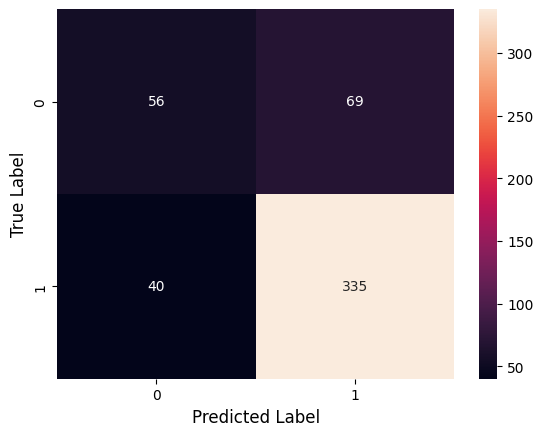

In [169]:
sns.heatmap(confusion_matrix_res, annot=True, fmt="d")
plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)
plt.savefig('/content/drive/MyDrive/models (3 calsses)/MobileNet 5th (2c) try(conf in)/confusion_matrix_res.png')
plt.show()

In [170]:
print(classification_report(test_set.classes, y_pred, labels = [0, 1],digits=4))

              precision    recall  f1-score   support

           0     0.5833    0.4480    0.5068       125
           1     0.8292    0.8933    0.8601       375

    accuracy                         0.7820       500
   macro avg     0.7063    0.6707    0.6834       500
weighted avg     0.7677    0.7820    0.7718       500



In [115]:
import numpy as np

def calculate_metrics(ypred, ytrue):
    # Calculate the confusion matrix
    confusion_matrix = np.zeros((3, 3))
    for i in range(len(ypred)):
        confusion_matrix[ytrue[i], ypred[i]] += 1

    # Calculate the total number of cases
    N = np.sum(confusion_matrix)

    # Calculate the number of cases in each class
    n1 = np.sum(confusion_matrix[0,:])
    n2 = np.sum(confusion_matrix[1,:])
    n3 = np.sum(confusion_matrix[2,:])

    # Calculate SE for each class
    SE1 = confusion_matrix[0,0] / (confusion_matrix[0,0] + confusion_matrix[0,1] + confusion_matrix[0,2])
    SE2 = confusion_matrix[1,1] / (confusion_matrix[1,0] + confusion_matrix[1,1] + confusion_matrix[1,2])
    SE3 = confusion_matrix[2,2] / (confusion_matrix[2,0] + confusion_matrix[2,1] + confusion_matrix[2,2])

    # Calculate SP for each class
    SP1 = (confusion_matrix[1,1] + confusion_matrix[2,2]) / (confusion_matrix[1,0] + confusion_matrix[1,1] + confusion_matrix[1,2] + confusion_matrix[2,0] + confusion_matrix[2,1] + confusion_matrix[2,2])
    SP2 = (confusion_matrix[0,0] + confusion_matrix[2,2]) / (confusion_matrix[0,0] + confusion_matrix[0,1] + confusion_matrix[0,2] + confusion_matrix[2,0] + confusion_matrix[2,1] + confusion_matrix[2,2])
    SP3 = (confusion_matrix[0,0] + confusion_matrix[1,1]) / (confusion_matrix[0,0] + confusion_matrix[0,1] + confusion_matrix[0,2] + confusion_matrix[1,0] + confusion_matrix[1,1] + confusion_matrix[1,2])

    # Calculate HS for each class
    HS1 = 2 * ((SE1 * SP1) / (SE1 + SP1))
    HS2 = 2 * ((SE2 * SP2) / (SE2 + SP2))
    HS3 = 2 * ((SE3 * SP3) / (SE3 + SP3))

    # Calculate overall SE, SP, AS, and HS
    SE = (n1/N * SE1) + (n2/N * SE2) + (n3/N * SE3)
    SP = (n1/N * SP1) + (n2/N * SP2) + (n3/N * SP3)
    AS = (SE+SP) /2
    HS = (2*SE*SP)/(SE+SP)

    #table stat general
    t = PrettyTable(['Class','SE','SP', 'AS','HS','Score'])
    t.add_row(['Normal',SE,SP,AS,HS,(HS+AS)/2])
    print(t)

In [171]:
calculate_metrics(test_set.classes, y_pred)

+--------+-----+--------------------+-----+-----+-------+
| Class  |  SE |         SP         |  AS |  HS | Score |
+--------+-----+--------------------+-----+-----+-------+
| Normal | nan | 0.6305412541254126 | nan | nan |  nan  |
+--------+-----+--------------------+-----+-----+-------+


<ipython-input-115-e1da21e8f79a>:20: RuntimeWarning: invalid value encountered in double_scalars
  SE3 = confusion_matrix[2,2] / (confusion_matrix[2,0] + confusion_matrix[2,1] + confusion_matrix[2,2])
